In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
from atomsci.ddm.pipeline import diversity_plots as dp
colors = ["#6EC8BE","#BE2369","#FFC30F","#694691","#EB1E23","#7682A4","#373C50","#A7DDD8",]
sns.set_palette(sns.color_palette(colors))
from scipy.spatial.distance import pdist, squareform

In [97]:
# method to translate ecfp fingerprints in DF back to bitvectors
from rdkit.DataStructs import ExplicitBitVect
def df_to_bitvect(df):
    bitvects = []
    for _, row in df.iterrows():
        bit_string = ''.join(row.astype(str))
        bitvect = ExplicitBitVect(len(bit_string))
        for i, bit in enumerate(bit_string):
            if bit == '1':
                bitvect.SetBit(i)
        bitvects.append(bitvect)
    return bitvects

In [95]:
from atomsci.ddm.pipeline import chem_diversity as cd
from atomsci.ddm.pipeline import dist_metrics
import logging
import pandas as pd
import matplotlib.pyplot as plt

def plot_tani_dist_distr(df, smiles_col, df_name, radius=2, featurized=False, subset_col='subset', subsets=False, ref_subset='train', plot_width=6, ndist_max=None, **metric_kwargs):
    """Generate a density plot showing the distribution of nearest neighbor distances between
    ecfp feature vectors, using the Tanimoto metric. Optionally split by subset.
    Args:
        df (DataFrame): A data frame containing, at minimum, a column of SMILES strings.
        smiles_col (str): Name of the column containing SMILES strings.
        df_name (str): Name for the dataset, to be used in the plot title.
        radius (int): Radius parameter used to calculate ECFP fingerprints. The default is 2, meaning that ECFP4 fingerprints are calculated.
        featurized (bool): If True, the input data frame contains precomputed features. If False, features are calculated on the fly.
        subset_col (str): Name of the column containing subset names.
        subsets (bool): If True, distances are only calculated for compounds not in the reference subset, and the distances computed are to the nearest neighbors in the reference subset.
        ref_subset (str): Reference subset for nearest-neighbor distances, if `subsets` is True.
        plot_width (float): Plot width in inches.
        ndist_max (int): Not used, included only for backward compatibility.
        metric_kwargs: Additional arguments to pass to metric. Not used, included only for backward compatibility.
    Returns:
        dist (DataFrame): Table of individual nearest-neighbor Tanimoto distance values. If subsets is True,
        the table will include a column indicating the subset each compound belongs to.
    """
    log = logging.getLogger('ATOM')
    
    num_cmpds = len(df)
    if num_cmpds > 50000:
        log.warning("Dataset has %d compounds, too big to calculate distance matrix" % num_cmpds)
        return

    if subsets and subset_col not in df.columns:
        log.warning(f"{subset_col} column not found. Calculating total tanimoto distances instead.")
        subsets=False
    feat_type = 'ecfp'
    dist_metric = 'tanimoto'
    calc_type='nearest'
    num_nearest=1
    if not subsets:
        smiles_arr1 = df[smiles_col].values
        if not featurized:
            dists=cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr1, calc_type=calc_type, num_nearest=num_nearest)
        else:
            fprints1_df = df[[col for col in df.columns if 'ecfp' in col]]
            fprints1=df_to_bitvect(fprints1_df)
            fprints2 = None
            within_dset = True
            dists=cd.calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type, num_nearest, within_dset)
            
        # flatten dists
        dists = dists.flatten()
        subs=['all']*len(dists)
        dists=pd.DataFrame(zip(dists,subs), columns=['dist','subset'])
    elif subsets:
        dists=pd.DataFrame([], columns=['dist','subset'])
        for subs in df[subset_col].unique():
            if subs==ref_subset:
                continue
            if not featurized:
                smiles_arr1 = df.loc[df[subset_col]==ref_subset, smiles_col].values
                smiles_arr2 = df.loc[df[subset_col]==subs, smiles_col].values
                diststmp = cd.calc_dist_smiles(feat_type, dist_metric, smiles_arr2, smiles_arr2=smiles_arr1, calc_type=calc_type, num_nearest=num_nearest)
            else:
                fprints1_df=df.loc[df['subset']==ref_subset, [col for col in df.columns if 'ecfp' in col]]
                fprints2_df=df.loc[df['subset']==subs, [col for col in df.columns if 'ecfp' in col]]
                fprints1=df_to_bitvect(fprints1_df)
                fprints2=df_to_bitvect(fprints2_df)
                within_dset=False
                diststmp=cd.calc_summary(dist_metrics.tanimoto(fprints1, fprints2), calc_type, num_nearest, within_dset)
            # flatten dists
            diststmp = diststmp.flatten()
            substmp=[subs]*len(diststmp)
            diststmp = pd.DataFrame(zip(diststmp,substmp), columns=['dist',subset_col])
            dists=pd.concat([dists,diststmp])
    
    dists=dists.reset_index(drop=True)
    fig, ax = plt.subplots(1, figsize=(plot_width, plot_width), dpi=300)
    sns.kdeplot(data=dists[dists.subset!=ref_subset], x='dist', hue=subset_col, legend=True, common_norm=False, common_grid=False, fill=False, ax=ax)
    ax.set_xlabel('%s distance' % dist_metric)
    ax.set_ylabel('Density')
    if not subsets:
        ax.set_title("%s dataset\nDistribution of %s nearest neighbor distances between %s feature vectors" % (
                      df_name, dist_metric, feat_type))
    else: 
        ax.set_title(f"{df_name} dataset: Distribution of {dist_metric} distances\nbetween {feat_type} feature vectors from non-{ref_subset} subsets\nto their nearest neighbors in the {ref_subset} subset")s
    return dists

In [113]:
datapath = '/Users/jayceepang/msse/capstone/atom2024/atom2024/notebooks/NEK/'
nek2moesmote = pd.read_csv(f'{datapath}NEK2/bind/NEK2_binding_moe_SMOTE_df.csv') 
nek2mfpsmote = pd.read_csv(f'{datapath}NEK2/bind/NEK2_binding_mfp_SMOTE_df.csv') 

nek2_desc = pd.read_csv(f'{datapath}NEK2/bind/NEK2_binding_moe_scaled_df.csv') 
nek2_mfp = pd.read_csv(f'{datapath}NEK2/bind/NEK2_binding_mfp_scaled_df.csv') 

In [62]:
mfp_dict = {}
for i in range (2048): 
    mfp_dict[str(i)] = f'ecfp_2048_{i}'

nek2mfpsmote = nek2mfpsmote.rename(columns=mfp_dict)
nek2_mfp = nek2_mfp.rename(columns=mfp_dict)
# nek2moesmote['origin'] = 'moe_SMOTE'
# nek2mfpsmote['origin'] = 'mfp_SMOTE'
# nek2_desc['origin'] = 'moe'
# nek2_mfp['origin'] = 'mfp'

In [118]:
nek2_og = nek2_desc.merge(nek2_mfp, on='compound_id',suffixes=('_moe', '_mfp'))
nek2_og.columns = nek2_og.columns.str.replace('_moe', '')
mfp_cols = [col for col in nek2_og.columns if '_mfp' in col]
nek2_og = nek2_og.drop(columns=mfp_cols)
nek2_og = nek2_desc.merge(nek2_mfp, on=['compound_id', 'base_rdkit_smiles', 'subset', 'fold', 'active'])
nek2_og['origin'] = 'original'
nek2_og


,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,BCUT_PEOE_1,BCUT_PEOE_2,BCUT_PEOE_3,BCUT_SLOGP_0_per_atom,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,origin
0,6.171916,-2.880666,-0.242820,-0.138540,3.174018,1.664387,2.956607,-2.776526,-1.873703,-6.030218,...,0,0,0,0,0,0,0,0,0,original
1,0.504051,0.725849,-0.489283,1.847024,0.319364,-0.163025,-0.395619,0.682256,0.269110,-0.059029,...,0,0,0,0,0,0,0,0,0,original
2,-1.005664,1.857896,-0.732021,1.562579,-0.222465,-0.258641,0.555600,-0.776457,0.794523,0.996309,...,0,0,0,0,0,0,0,0,0,original
3,-0.272463,0.356568,-0.742466,1.119058,0.391476,0.992658,-0.464873,0.315869,0.916609,0.039975,...,0,0,0,0,0,0,0,0,0,original
4,1.507075,-0.643926,1.305948,-0.705561,1.121426,1.445349,0.459030,1.731704,-1.692399,-0.232629,...,0,0,0,0,0,0,0,0,0,original
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,-0.829305,-0.606676,-0.711927,-0.580871,-1.457042,-1.209951,1.095581,-0.537771,1.347102,0.065689,...,0,0,0,0,0,0,0,0,0,original
1404,1.325649,-1.222164,2.374258,-1.635889,1.987426,1.693552,-0.893856,0.765541,-1.947318,-2.045763,...,0,0,0,0,0,0,0,0,0,original
1405,1.130839,-0.968577,0.678757,-0.691671,0.130626,0.118424,0.656058,-1.451143,-0.473444,0.291278,...,0,0,0,0,0,0,0,0,0,original
1406,-0.073978,-0.955461,-0.432754,-0.659996,-1.040959,-0.678455,-0.542517,0.329226,0.102786,0.353850,...,0,0,0,0,0,0,0,0,0,original


In [119]:
# nek2mfpsmote_train = nek2mfpsmote[nek2mfpsmote['subset'] == 'train']
# nek2moesmote_train = nek2moesmote[nek2moesmote['subset'] == 'train']
common_cols = ['base_rdkit_smiles', 'compound_id', 'fold', 'subset', 'active']
nek2mfpsmote = nek2mfpsmote.drop(columns=common_cols)
nek2smote = pd.concat([nek2moesmote, nek2mfpsmote], axis=1)
print(nek2smote.shape)
nek2smote

(2443, 2359)


,subset,compound_id,base_rdkit_smiles,fold,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,train,synthetic SMOTE,synthetic SMOTE,synthetic SMOTE,6.171916,-2.880666,-0.242820,-0.138540,3.174018,1.664387,...,0,0,0,0,0,0,0,0,0,0
1,train,synthetic SMOTE,synthetic SMOTE,synthetic SMOTE,0.504051,0.725849,-0.489283,1.847024,0.319364,-0.163025,...,0,0,0,0,0,0,0,0,0,0
2,train,synthetic SMOTE,synthetic SMOTE,synthetic SMOTE,-1.005664,1.857896,-0.732021,1.562579,-0.222465,-0.258641,...,0,0,0,0,0,0,0,0,0,0
3,train,synthetic SMOTE,synthetic SMOTE,synthetic SMOTE,-0.272463,0.356568,-0.742466,1.119058,0.391476,0.992658,...,0,0,0,0,0,0,0,0,0,0
4,train,synthetic SMOTE,synthetic SMOTE,synthetic SMOTE,1.507075,-0.643926,1.305948,-0.705561,1.121426,1.445349,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2438,test,kdb_1627,CN[C@H]1C[C@@H]2O[C@](C)([C@H]1OC)n1c3ccccc3c3...,fold1,-0.829305,-0.606676,-0.711927,-0.580871,-1.457042,-1.209951,...,0,0,0,0,0,0,0,0,0,0
2439,test,kdb_2758,c1ccc(-c2ccnc3[nH]ccc23)cc1,fold1,1.325649,-1.222164,2.374258,-1.635889,1.987426,1.693552,...,0,0,0,0,0,0,0,0,0,0
2440,test,kdb_2288,COCCOCCOc1cc2ncc3c4ccc(C#N)cc4[nH]c3c2cc1OC,fold1,1.130839,-0.968577,0.678757,-0.691671,0.130626,0.118424,...,0,0,0,0,0,0,0,0,0,0
2441,test,kdb_2768,CNC(=O)c1ccccc1Nc1nc(Nc2ccc(N3CCOCC3)cc2)ncc1Cl,fold1,-0.073978,-0.955461,-0.432754,-0.659996,-1.040959,-0.678455,...,0,0,0,0,0,0,0,0,0,0


In [120]:
smote_list = [f'smote_{i}' for i in range(nek2moesmote_train.shape[0])]

# train, test, smote do it separately for moe and mfp

In [56]:
nek2moesmote = pd.read_csv(f'{datapath}NEK2/bind/NEK2_binding_moe_SMOTE_df.csv') 
nek2mfpsmote = pd.read_csv(f'{datapath}NEK2/bind/NEK2_binding_mfp_SMOTE_df.csv') 
nek2_desc = pd.read_csv(f'{datapath}NEK2/bind/NEK2_binding_moe_scaled_df.csv') 
nek2_mfp = pd.read_csv(f'{datapath}NEK2/bind/NEK2_binding_mfp_scaled_df.csv') 
mfp_dict = {}
for i in range (2048): 
    mfp_dict[str(i)] = f'ecfp_2048_{i}'

nek2mfpsmote = nek2mfpsmote.rename(columns=mfp_dict)
nek2_mfp = nek2_mfp.rename(columns=mfp_dict)
common_cols2 = ['base_rdkit_smiles', 'compound_id', 'fold', 'subset']
nek2_original = nek2_desc

nek2moesmote = nek2moesmote[nek2moesmote['subset'] == 'train']
nek2moesmote  =nek2moesmote.drop(columns=common_cols)
nek2moesmote['subset'] = 'train_SMOTE'

nek2moe = pd.concat([nek2_original, nek2moesmote])
nek2moe.shape

(3568, 311)

In [105]:
nek2moesmote = pd.read_csv(f'{datapath}NEK2/bind/NEK2_binding_moe_SMOTE_df.csv') 
nek2mfpsmote = pd.read_csv(f'{datapath}NEK2/bind/NEK2_binding_mfp_SMOTE_df.csv') 
nek2_desc = pd.read_csv(f'{datapath}NEK2/bind/NEK2_binding_moe_scaled_df.csv') 
nek2_mfp = pd.read_csv(f'{datapath}NEK2/bind/NEK2_binding_mfp_scaled_df.csv') 
nek2moesmote_train = nek2moesmote[nek2moesmote['subset'] == 'train']
nek2moesmote_train.shape # 2160 

mfp_dict = {}
for i in range (2048): 
    mfp_dict[str(i)] = f'ecfp_2048_{i}'
smote_list = [f'smote_{i}' for i in range(nek2moesmote_train.shape[0])]

nek2mfpsmote = nek2mfpsmote.rename(columns=mfp_dict)
nek2_mfp = nek2_mfp.rename(columns=mfp_dict)
nek2=pd.concat([nek2_desc,nek2_mfp]).reset_index(drop=True)

nek2moesmote_train = nek2moesmote[nek2moesmote['subset'] == 'train']
nek2mfpsmote_train = nek2mfpsmote[nek2mfpsmote['subset'] == 'train']
nek2moesmote_train['compound_id'] = smote_list
nek2mfpsmote_train['compound_id'] = smote_list
nek2mfpsmote_train
nek2smote= pd.concat([nek2moesmote_train, nek2mfpsmote_train]).reset_index(drop=True)
nek2smote['subset'] ='train_SMOTE'
nek2moesmote_train['subset'] = 'train_SMOTE'
nek2mfpsmote_train['subset'] = 'train_SMOTE'

final_nek2 =pd.concat([nek2,nek2smote]).reset_index(drop=True)

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_65480/467670178.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nek2moesmote_train['compound_id'] = smote_list
/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_65480/467670178.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nek2mfpsmote_train['compound_id'] = smote_list
/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_65480/467670178.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [110]:
final_nek2

,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,BCUT_PEOE_1,BCUT_PEOE_2,BCUT_PEOE_3,BCUT_SLOGP_0_per_atom,...,ecfp_2048_2038,ecfp_2048_2039,ecfp_2048_2040,ecfp_2048_2041,ecfp_2048_2042,ecfp_2048_2043,ecfp_2048_2044,ecfp_2048_2045,ecfp_2048_2046,ecfp_2048_2047
0,6.171916,-2.880666,-0.242820,-0.138540,3.174018,1.664387,2.956607,-2.776526,-1.873703,-6.030218,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.504051,0.725849,-0.489283,1.847024,0.319364,-0.163025,-0.395619,0.682256,0.269110,-0.059029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1.005664,1.857896,-0.732021,1.562579,-0.222465,-0.258641,0.555600,-0.776457,0.794523,0.996309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-0.272463,0.356568,-0.742466,1.119058,0.391476,0.992658,-0.464873,0.315869,0.916609,0.039975,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.507075,-0.643926,1.305948,-0.705561,1.121426,1.445349,0.459030,1.731704,-1.692399,-0.232629,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [106]:
# def plot_corr_matrices(dfs = [nek2, nek2[nek2.subset!='smote']], 
#                     dflabs = ['NEK2 ECFP_1024', 'NEK2 MOE'],
#                     firstcols = ["ecfp2_1024_0", "ASA+_per_atom"], 
#                     lastcols = ["ecfp2_1024_1023", "zagreb_per_atom"], 
#                     rowlabelcols = ['subset','subset'],
#                     collabelcols=['active','active'],
#                     dataset_names = ["all compounds", "non-SMOTE compounds"]):
def plot_corr_matrices(dfs, 
                    dflabs = ['NEK2 ECFP_1024', 'NEK2 MOE'],
                    firstcols = ["ecfp_2048_0", "ASA+_per_atom"], 
                    lastcols = ["ecfp_2048_2047", "zagreb_per_atom"], 
                    rowlabelcols = ['subset','subset'],
                    collabelcols=['active','active'],
                    dataset_names = ["all compounds", "non-SMOTE compounds"]):
    '''
    pass in a list of dataframes with associated labels, the columns to subset on for computing the UMAP, and which columns should reflect the labels and values
    computes umap and returns a strip of UMAP plots using each item in each list
    '''
    corr_dfs=[]
    for i, df in enumerate(dfs):
        print("Computing correlation matrix for", dflabs[i])
        df=df.set_index([rowlabelcols[i]])
        map_df = df.loc[:,firstcols[i]:lastcols[i]]
        corr_matrix = pd.DataFrame(squareform(pdist(map_df, metric='jaccard')), columns=map_df.index, index=map_df.index)
        lut = dict(zip(df.index.unique(), colors))
        lut2=dict(zip(df[collabelcols[i]].unique(), colors[-df[collabelcols[i]].nunique():]))
        row_colors = map_df.index.map(lut)
        col_colors = df[collabelcols[i]].map(lut2)
        g=sns.clustermap(corr_matrix, row_colors=row_colors, col_colors=col_colors)
        g.fig.suptitle(f"{dflabs[i]} correlation matrix of {dataset_names[i]}", y=1.02)
        corr_dfs.append(corr_matrix)
    return corr_dfs

Computing correlation matrix for NEK2 ECFP_1024


/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method

Computing correlation matrix for NEK2 MOE


/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/jayceepang/msse/capstone/atomsci/lib/python3.9/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method

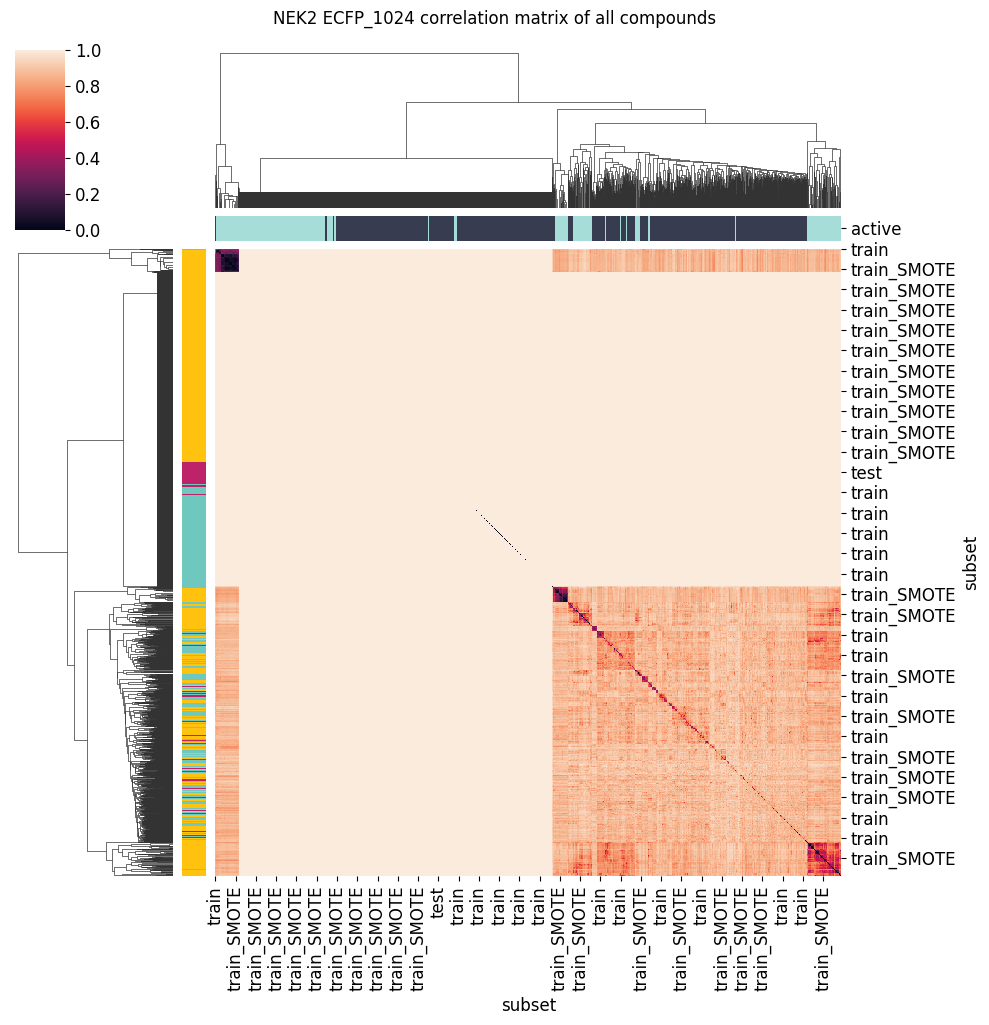

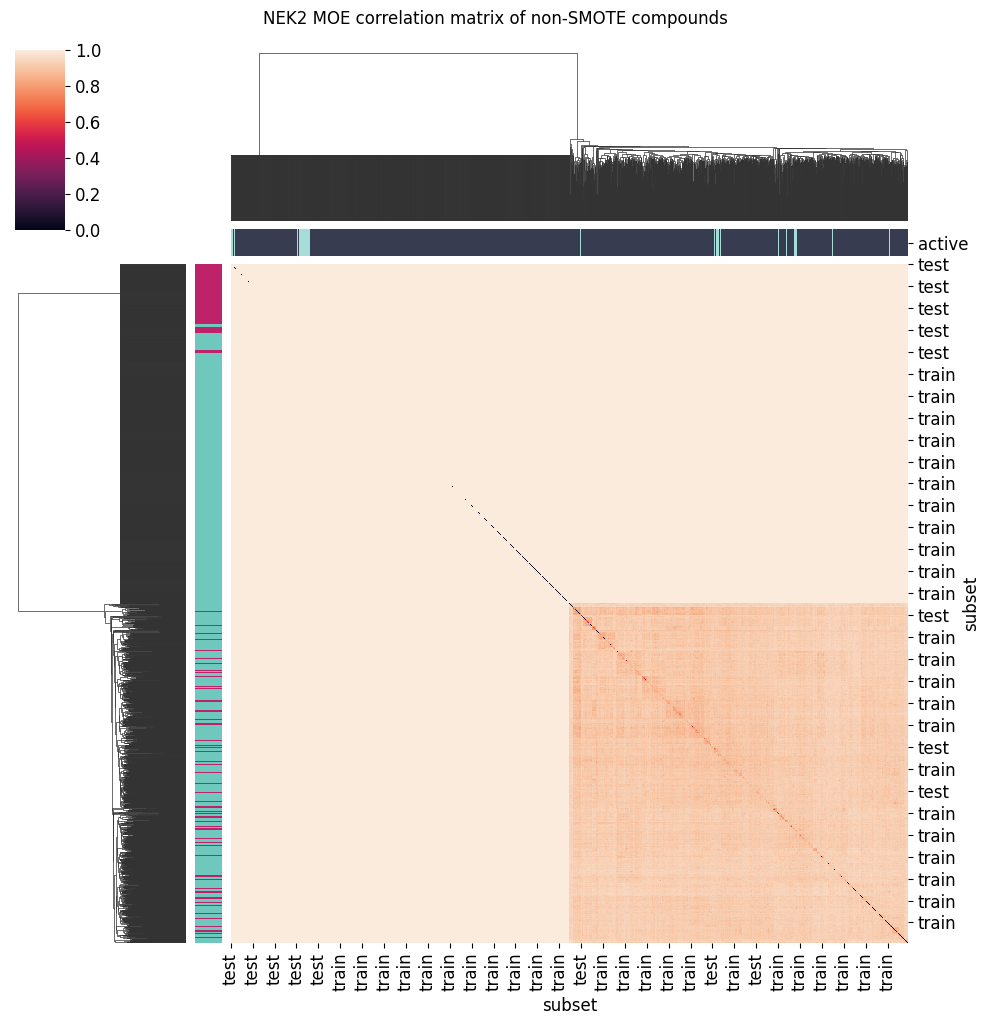

In [107]:
corr_dfs=plot_corr_matrices(dfs=[final_nek2, final_nek2[final_nek2['subset']!='train_SMOTE']])

/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_65480/1271048568.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dists=pd.concat([dists,diststmp])
/var/folders/wb/cvnnx9qn3tj18cq5_9wx39xm0000gn/T/ipykernel_65480/1271048568.py:79: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dists[dists.subset!=ref_subset], x='dist', hue=subset_col, legend=True, common_norm=False, common_grid=False, fill=False, ax=ax)


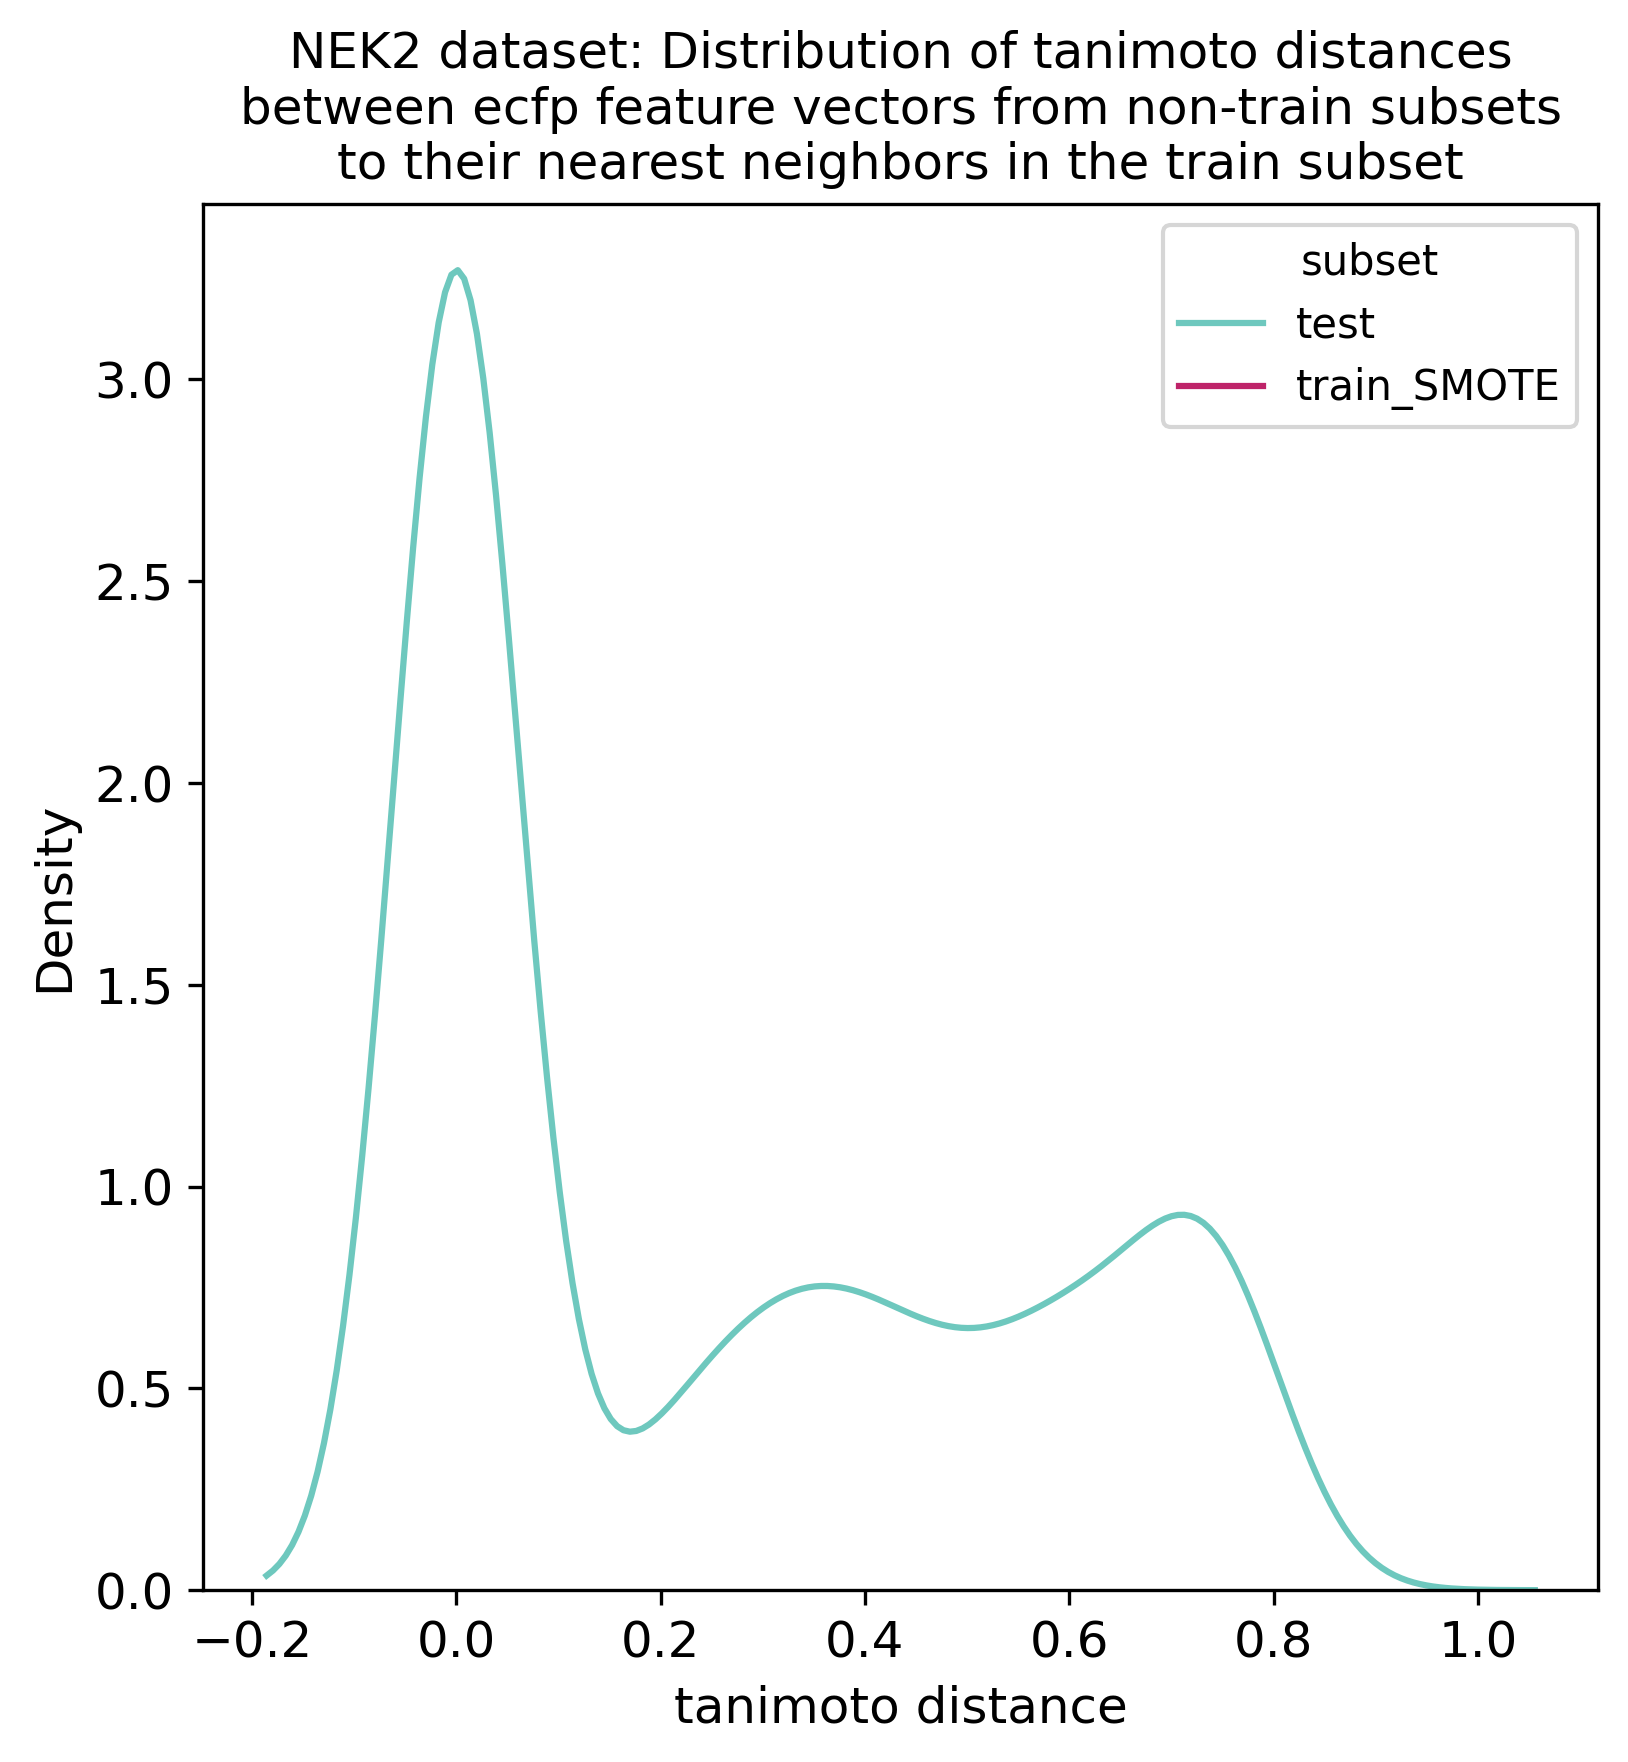

In [112]:
dists=plot_tani_dist_distr(final_nek2, 'base_rdkit_smiles', 'NEK2', radius=2, subsets=True, featurized=True)